In [1]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt 
import numpy as np
import datetime as dt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../bike_sharing_demand/src/')
import model_linear

In [26]:
df = pd.read_csv('../POWER_Point_Hourly_20180101_20241231_051d04N_0114d05W_LST.csv')
df_nsr = pd.read_csv('../solar_rad_nsrdb_2018.csv')

df = df.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'})
df['date'] = pd.to_datetime(df[['year','month','day','hour']] )
df['date']

0       2018-01-01 00:00:00
1       2018-01-01 01:00:00
2       2018-01-01 02:00:00
3       2018-01-01 03:00:00
4       2018-01-01 04:00:00
                ...        
61363   2024-12-31 19:00:00
61364   2024-12-31 20:00:00
61365   2024-12-31 21:00:00
61366   2024-12-31 22:00:00
61367   2024-12-31 23:00:00
Name: date, Length: 61368, dtype: datetime64[ns]

In [3]:
# df[ (df['YEAR'] == 2024) & (df['MO'] == 6)  ].describe()
# Data only run until end of June 2024

In [4]:
dfd = df.set_index('date')
# dfd.between_time('2018-06-20', '2018-06-21')
# dfd['20180620':'20180621']

In [27]:
dfp = pd.read_csv('../Solar_Energy_Production_20250219.csv')
dfp['date'] = pd.to_datetime(dfp['date'])
dfp = dfp[dfp['name'] != "Telus Spark"]

# slice the data to only be between 2018/01/01 - 2024/06/30
df_s = dfp.sort_values('date')
# start = df_s.date.searchsorted(dt.datetime(2018, 1, 1,0))
# end = df_s.date.searchsorted(dt.datetime(2024, 6, 30,23))
# df_sub = df_s.iloc[start:end]
df_sub = df_s.set_index('date')['20180101':'20240630']
df_sub

,name,id,address,kWh,public_url,installationDate,uid
date,,,,,,,
2018-01-01 00:00:00,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,1.317,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502018-01-01 00:00:00
2018-01-01 01:00:00,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,1.324,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502018-01-01 01:00:00
2018-01-01 02:00:00,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,1.331,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502018-01-01 02:00:00
2018-01-01 03:00:00,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,1.361,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502018-01-01 03:00:00
2018-01-01 04:00:00,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,1.386,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502018-01-01 04:00:00
...,...,...,...,...,...,...,...
2024-06-30 21:00:00,Richmond - Knob Hill Community Hall,332785,2433 26 AV SW,2.000,https://monitoringpublic.solaredge.com/solared...,2016/11/21,332785-2024-06-30 21:00:00
2024-06-30 21:00:00,Glenmore Water Treatment Plant,355827,1634 56 AV SW,98.000,https://monitoringpublic.solaredge.com/solared...,2017/01/11,355827-2024-06-30 21:00:00
2024-06-30 21:00:00,Manchester Building M,570079,651M 25 AV SE,9.000,https://monitoringpublic.solaredge.com/solared...,2017/10/23,570079-2024-06-30 21:00:00


In [6]:
df_merged = pd.merge_asof(df_sub, df, on='date')

df_merged = df_merged.set_index('date')

<Axes: xlabel='ALLSKY_SFC_SW_DWN', ylabel='kWh'>

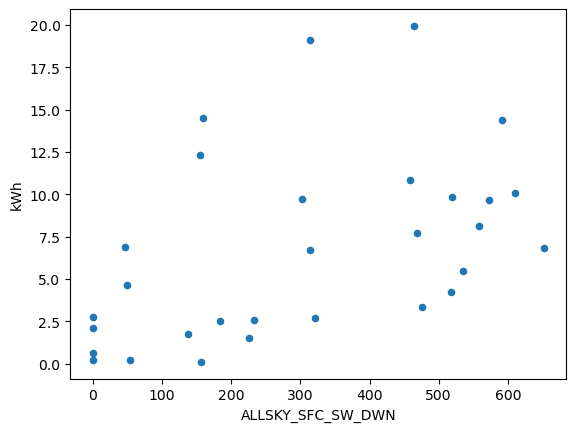

In [7]:
df_pp = df_merged['20210810':'20210811'][['kWh','ALLSKY_SFC_SW_DWN','name']]
df_pp[df_pp['name'] == 'CFD Firehall #7'].plot(x='ALLSKY_SFC_SW_DWN', y = 'kWh', kind = 'scatter')

In [82]:
# df_pp.ALLSKY_SFC_SW_DWN.plot()
# df_pp.kWh.plot(color = 'r')
# location = 'Manchester Building M'
# df_pp[df_pp['name'] == location].ALLSKY_SFC_SW_DWN.plot(color = 'r', logy = True)
# df_pp[df_pp['name'] == location].kWh.plot(logy = True)


In [8]:
# lets try to fit a simple linear regression 
# first lets sum all the locations together 
func_dict = {'kWh': 'sum', 'month': 'median', 
            'day': 'median', 'hour': 'median', 'ALLSKY_SFC_SW_DWN':'median'}
df_merged_all_locs = df_merged[['name','kWh',
                           'month','day','hour',
                           'ALLSKY_SFC_SW_DWN']].groupby('date').aggregate(func_dict)

# data after 25 September 2023 suddenly change to units of Watts instead of kW
# so we need to divide it by 1000
date_start = '20230925'
date_end = '20240630'
df_merged_all_locs.loc[date_start:date_end, 'kWh'] = df_merged_all_locs.loc[date_start:date_end, 'kWh'] * (1/1000)
df_merged_all_locs[date_start:date_end]['kWh'].describe()

count    3364.000000
mean      245.834491
std       272.294954
min         0.000008
25%        19.109229
50%       129.030469
75%       407.968398
max      1008.813780
Name: kWh, dtype: float64

In [119]:
# does this make sense?
# df_merged_all_locs['20190921':'20190921']
date = '20180102'
print( f"manual summing: {df_merged[date:date]['kWh'].iloc[0:10].sum() }" )
print(f"groupby: {df_merged_all_locs[date:date]['kWh']}")

manual summing: 7.028
groupby: date
2018-01-02 00:00:00     0.547
2018-01-02 01:00:00     0.558
2018-01-02 02:00:00     0.558
2018-01-02 03:00:00     0.552
2018-01-02 04:00:00     0.563
2018-01-02 05:00:00     0.559
2018-01-02 06:00:00     0.562
2018-01-02 07:00:00     0.571
2018-01-02 08:00:00     0.625
2018-01-02 09:00:00     1.933
2018-01-02 10:00:00    12.331
2018-01-02 11:00:00    32.355
2018-01-02 12:00:00    76.651
2018-01-02 13:00:00    82.000
2018-01-02 14:00:00    39.280
2018-01-02 15:00:00    21.224
2018-01-02 16:00:00     1.747
Name: kWh, dtype: float64


In [141]:
# date = '20190401'
# loc = "Southland Leisure Centre"
# df_merged[df_merged["name"] == loc][date:date]

In [9]:
features = df_merged_all_locs.drop(columns=['kWh','ALLSKY_SFC_SW_DWN']).to_numpy()[:,1:]
target = df_merged_all_locs['kWh'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3,
                                            random_state = 1)

# split data into train/test/validation

x_train, x_, y_train, y_ = train_test_split(features, target, test_size=0.4,
                                            random_state = 1)
# Split the subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

linear_model_daily = model_linear.ModelLinear(n_poly = 7, n_features = 6)
trained_model = linear_model_daily.train_model(
                    x_train = x_train,
                    y_train = y_train)

pred_train = trained_model.predict(x_train)
pred_cv = trained_model.predict(x_cv)

mean_absolute_error(y_cv, pred_cv)

/Users/markhague/miniconda3/envs/sklearn-env/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=6 is greater than n_features=2. All the features will be returned.
  warnings.warn(


231.11444033677984

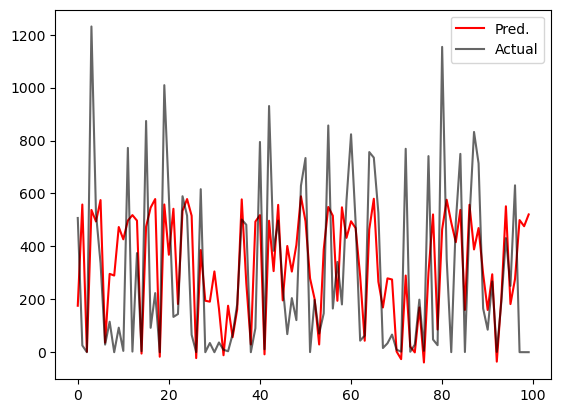

In [12]:
xi = 4000 
stride = 100

plt.plot(pred_cv[xi:xi+stride], color = 'r', label = 'Pred.')
plt.plot(y_cv[xi:xi+stride], color = 'k', label = 'Actual', alpha = .6)
# plt.yscale('log')
plt.legend()

In [22]:
date_start = '20230925'
date_end = '20240630'
df_merged_all_locs.loc[date_start:date_end, 'kWh'] = df_merged_all_locs.loc[date_start:date_end, 'kWh'] * (1/1000)
df_merged_all_locs[date_start:date_end]['kWh'].describe()

count    3.364000e+03
mean     2.458345e-04
std      2.722950e-04
min      8.000000e-12
25%      1.910923e-05
50%      1.290305e-04
75%      4.079684e-04
max      1.008814e-03
Name: kWh, dtype: float64

In [18]:
df_merged_all_locs

,kWh,month,day,hour,ALLSKY_SFC_SW_DWN
date,,,,,
2018-01-01 00:00:00,1.317,1.0,1.0,0.0,0.00
2018-01-01 01:00:00,1.324,1.0,1.0,1.0,0.00
2018-01-01 02:00:00,1.331,1.0,1.0,2.0,0.00
2018-01-01 03:00:00,1.361,1.0,1.0,3.0,0.00
2018-01-01 04:00:00,1.386,1.0,1.0,4.0,0.00
...,...,...,...,...,...
2024-06-30 17:00:00,292641.741,6.0,30.0,17.0,171.40
2024-06-30 18:00:00,295102.984,6.0,30.0,18.0,70.32
2024-06-30 19:00:00,176820.063,6.0,30.0,19.0,19.27
